# NN Ensemble implementation of Zimmerman, Steven and Fox, Chris and Kruschwitz, Udo Improving Hate Speech Detection with Deep Learning Ensembles

## Importing Necessary Packages

In [0]:
import matplotlib.pyplot as plt
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from gensim.models.keyedvectors import KeyedVectors
import re
import sys
import nltk
import seaborn
import numpy as np
import pandas as pd

# fix random seed for reproducibility
np.random.seed(21)

# Note tqdm import try
try:
    from tqdm.notebook import tqdm
except:
    import tqdm


%matplotlib inline

## Loading the training data

In [0]:
X_train_davidson = pd.read_csv("hate_speech_labelled_data/labeled_data.csv")
X_train_davidson.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Columns key:

-   count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


-   hate_speech = number of CF users who judged the tweet to be hate speech.


-   offensive_language = number of CF users who judged the tweet to be offensive.


-   neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


-   class = class label for majority of CF users.

    -   0 - hate speech
    -   1 - offensive  language
    -   2 - neither

-   tweet = raw tweet text


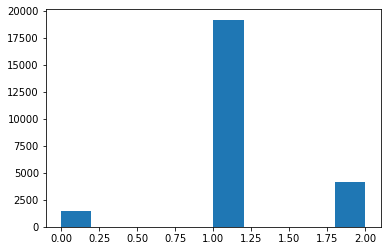

In [0]:
X_train_davidson['class'].hist(grid=False)

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

# Ensemble Neural Network *Implementation*

## Import required and custom modules

In [0]:
import util.nn_ensemble.evaluation as evaluation
import util.nn_ensemble.helper as helper
import util.nn_ensemble.nlp as nlp

## Utility function

For preprocessing tweets for acquiring the word to vec embeddings

In [0]:
def get_cnn_embeddings(word_embeddings, tweets_tokenized, max_tokens=50):
    '''twitter embedding model only'''
    corpus_vecs = []
    for tweet in tweets_tokenized:
        tweet_vecs = [[0.0 for x in range(400)] for x in range(max_tokens)]
        for cnt, token in enumerate(tweet):
            try:
                tweet_vecs[cnt] = (word_embeddings[token].tolist())
            except:
                continue
        # tweet_vecs.append(embedding_sum/tweet_length)  # NOTE: L1 and High C 10+  better for this scenario
        # NOTE: L2 and Low C .01- better for this scenario
        corpus_vecs.append(tweet_vecs)
    return np.array(corpus_vecs)

## Defining CNN and Ensemble model classes

In [0]:
class CNN_model:

    def __init__(self,
                 input_size=50,
                 output_size=3,
                 loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'],
                 random_seed=87):
        self.input_size = input_size     # tokens
        self.output_size = output_size

        np.random.seed(random_seed)

        self.model = Sequential()
        self.model.add(Conv1D(filters=150, kernel_size=3,
                              padding='same', activation='relu',
                              input_shape=(input_size, 400)))
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Dense(250, activation='relu'))
        self.model.add(Dense(3, activation='sigmoid'))
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def fit(self, X_train, y_train,
            batch_size=32,
            epochs=3,
            validation_split=0.2,
            **kwargs):
        self.model.fit(X_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_split=validation_split,
                       **kwargs)

    def predict(self, X, verbose=0):
        return self.model.predict(X, verbose=verbose)

    def evaluate_model(self, y_test, y_pred):
        # output evaluation data
        print('--------- INDIVIDUAL CNN Model results ---------')
        print('--------- F-1/precision/recall report  ---------')
        print('---------         MACRO F1             ---------')
        print(f1_score(y_test, y_pred, average='macro'))
        print('---------         F1 Matrix            ---------')
        print(evaluation.evaluate_results(y_test, y_pred))

    def get_model_summary(self):
        return self.model.summary()

    def save_model(self, save_model_path):
        self.model.save(save_model_path)  # creates a HDF5 file 'my_model.h5'

    def load_model(self, load_model_path):
        self.model = load_model(load_model_path)


class Ensemble_CNN_model:

    def __init__(self,
                 load_weight_path=None,
                 num_ensemble_models=10,
                 input_size=50,
                 output_size=3,
                 random_seed=87):

        self.ensemble_cnns = [None]*num_ensemble_models

        for i in range(num_ensemble_models):
            np.random.seed(int(random_seed*(i+1)))
            self.ensemble_cnns[i] = CNN_model(input_size=input_size,
                                              output_size=output_size)
            if load_weight_path:
                try:
                    self.ensemble_cnns[i].load_model(load_weight_path+f'_{i}')
                except:
                    print(
                        f'Model weight not available: {load_weight_path}_{i}')

    def predict(self, X):
        aggregate_y_pred = []
        encoder = None

        RANGE = len(self.ensemble_cnns)
        for cnn_model in self.ensemble_cnns:
            y_soft_max = cnn_model.predict(X)
            y_pred = y_soft_max.argmax(axis=1)
            aggregate_y_pred.append(y_soft_max)

        # ADD ALL RESULTS
        sum_of_ys = aggregate_y_pred[0]
        for i in [x + 1 for x in range(RANGE - 1)]:
            sum_of_ys += aggregate_y_pred[i]

        # DIVIDE BY RANGE FOR MEAN
        sum_of_ys /= RANGE

        # ENCODE PREDS
        encoded_preds = sum_of_ys.argmax(axis=1)
        print(len(sum_of_ys), len(encoded_preds))
        return encoded_preds

    def fit_and_eval(self, X_train, y_train, X_test, y_test,
                     save_weight_path=None,
                     validation_split=0.2,
                     batch_size=32,
                     epochs=3,
                     **kwargs):
        aggregate_y_pred = []
        encoder = None

        RANGE = len(self.ensemble_cnns)
        for cnn_model in self.ensemble_cnns:
            y_encoder, y_one_hot = helper.one_hot_encode_y(y_train)
            cnn_model.fit(X_train, y_one_hot, epochs=epochs,
                          batch_size=batch_size)

            if save_weight_path:
                cnn_model.save_model(save_weight_path)

            y_soft_max = cnn_model.predict(X_test)
            encoded_preds = y_soft_max.argmax(axis=1)
            decoded_preds = y_encoder.inverse_transform(encoded_preds)

            cnn_model.evaluate_model(
                y_test, decoded_preds)  # print indv results
            aggregate_y_pred.append(y_soft_max)

        # ADD ALL RESULTS
        sum_of_ys = aggregate_y_pred[0]
        for i in [x + 1 for x in range(RANGE - 1)]:
            sum_of_ys += aggregate_y_pred[i]

        # DIVIDE BY RANGE FOR MEAN
        sum_of_ys /= RANGE

        # ENCODE PREDS
        encoded_preds = sum_of_ys.argmax(axis=1)
        decoded_preds = y_encoder.inverse_transform(encoded_preds)
        print(len(sum_of_ys), len(encoded_preds), len(decoded_preds))
        self.evaluate_model(y_test, decoded_preds)

    def evaluate_model(self, y_test, y_pred):
        print('--------- FINAL ENSEMBLE Model results ---------')
        print('---------  F-1/precision/recall report ---------')
        print('---------            MACRO F1:         ---------')
        print(f1_score(y_test, y_pred, average='macro'))
        print('---------            F1 Matrix         ---------')
        print(evaluation.evaluate_results(y_test, y_pred))

## Load the word vectors 

In [0]:
word_vectors = KeyedVectors.load_word2vec_format('pre_trained_models/word2vec_twitter_tokens.bin', 
                                                 binary=True,
                                                 unicode_errors='ignore')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# --------- EMBEDDING MODELS ----------- #
#     Load tweet embeddings lookup       #
# ---------------- GODIN --------------- #

print('Extracting features')
X_train = get_cnn_embeddings(word_vectors,
                             map(lambda y: nlp.replace_tokens(y),
                                 nlp.tokenize_tweets(X_train_davidson['tweet'],
                                                     lower_case=LOWER_CASE_TOKENS)),
                             max_tokens=50)

X_train = np.array(X_train)
Y_train = (X_train_davidson['class'].astype(int))

# Concatenate wassem data to davidson data
X_train = np.concatenate([X_train, X_data_w])
Y_train = np.concatenate([Y_train, y_data_w])

Extracting features


In [0]:
# sklearn train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=7)

## Train the ensemble model

In [0]:
ensemble10 = Ensemble_CNN_model(random_seed=101, num_ensemble_models=20)

class_weight = {0: 4.,
                1: 1.,
                2: 1.}

ensemble10.fit_and_eval(X_train_split, y_train_split, X_test_split, y_test_split,
                        epochs=4, batch_size=32, class_weight=class_weight)

Train on 16852 samples, validate on 4213 samples
Epoch 1/4
16852/16852 [==============================] - 6s 330us/step - loss: 0.1890 - accuracy: 0.9297 - val_loss: 0.1769 - val_accuracy: 0.9410
Epoch 2/4
16852/16852 [==============================] - 5s 317us/step - loss: 0.1311 - accuracy: 0.9497 - val_loss: 0.1636 - val_accuracy: 0.9422
Epoch 3/4
16852/16852 [==============================] - 5s 319us/step - loss: 0.0938 - accuracy: 0.9642 - val_loss: 0.1794 - val_accuracy: 0.9336
Epoch 4/4
16852/16852 [==============================] - 5s 319us/step - loss: 0.0572 - accuracy: 0.9786 - val_loss: 0.2299 - val_accuracy: 0.9236
--------- INDIVIDUAL CNN Model results ---------
--------- F-1/precision/recall report  ---------
---------         MACRO F1             ---------
0.7403229181477727
---------         F1 Matrix            ---------
              precision    recall  f1-score   support

           0     0.3531    0.5667    0.4351       210
           1     0.9526    0.9195    0.